<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-lightning/03-finetuning-with-lightning-flash/02_automatic_speech_recognition_using_flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Automatic speech recognition using Flash

Recognizing speech from an audio file is perhaps one of the most widely used applications
of AI. It's part of smartphone speakers such as Alexa, as well as automatically generated
captions for video streaming platforms such as YouTube, and also many music platforms.

It can detect speech in an audio file and convert it into text. Detection of speech involves
various challenges such as speaker modalities, pitch, and pronunciation, as well as dialect
and language itself.

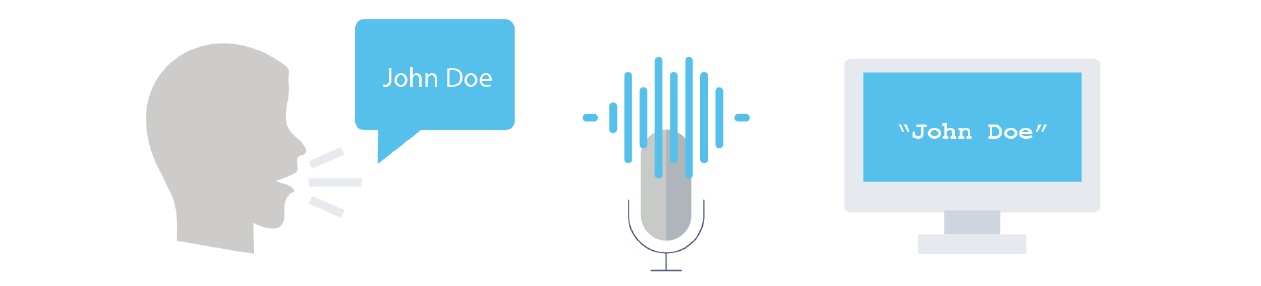

To train a model for Automatic Speech Recognition (ASR), we need a training dataset
that is a collection of audio files along with the corresponding text transcription that
describes that audio. The more diverse the set of audio files with people from different age
groups, ethnicities, dialects, and so on is, the more robust the ASR model will be for the
unseen audio files.

While there are many architectures available for ASR, wav2vec is a really good
cross-lingual architecture developed by Facebook AI. 

It can arguably work on any
language and is extremely scalable. It has recently outperformed the LibriSpeech
benchmark. It was first published in the paper wav2sec: Unsupervised Pre-training
for Speech Recognition.

The wav2vec model is an improvement over the BERT Transformer model, which
we saw in Chapter 3, Using Pre-Trained Models. This model uses much less labeled
data than other models since it relies on "self-supervised learning." It learns the latent
representation of audio files in a set of small speech units (25 ms), which are shorter than
the phenomes. 

These small latent representations are fed into the transformer in masked
form along with knowledge from the entire sequence. A contrastive loss function is used
to find the converge of masked positions and speech units. It uses the concepts of
self-supervision and contrastive loss.

The pre-trained model is trained on nearly 960 hours of audio. The most interesting part
of the architecture is that it is cross-lingual and has been tried in various languages.
We will try this model for a Scottish language dataset.

##Setup

In [ ]:
#install correct version as defined in the Technical Req
!pip install pytorch-lightning --quiet
!pip install lightning-flash --quiet
!pip install 'lightning-flash[audio,image, video, text]' --quiet
!pip install Pillow==9.0.0

In [ ]:
import torch
import flash

from flash import Trainer
from flash.audio import SpeechRecognitionData, SpeechRecognition

from sklearn.model_selection import train_test_split

import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

%matplotlib inline

In [2]:
import urllib3
urllib3.disable_warnings()

Let's download the Scottish language dataset.

In [ ]:
!wget https://www.openslr.org/resources/83/scottish_english_female.zip
!mkdir content
!unzip /content/scottish_english_female.zip

In [20]:
!rm -rf *.zip.1

##Dataset

Here, we are collecting the dataset and down-sampling it to use
only 6% of the dataset. This is done because of compute resource limitation. 

If you have
more compute available, you can try a higher number or the entire dataset.

Let's load the dataset.

In [22]:
random.seed(10)

scottish_df = pd.read_csv("/content/line_index.csv", header=None, names=["not_required", "speech_files", "targets"])
scottish_df = scottish_df.sample(frac=0.06)
print(scottish_df.shape)
scottish_df.head()

(54, 3)


,not_required,speech_files,targets
187,EN0031,scf_02484_01972157810,Nuclear fusion on a large scale in an explosi...
599,SC0187,scf_05223_00374512588,There is no easier way to go from Broughty Fe...
44,EN0986,scf_04310_01232177749,After getting sacked by Brisbane Lions Albert...
483,EN1267,scf_07049_00635301457,Aromatherapy has shown some tentative benefit...
548,EN0120,scf_07049_01518194427,Since you're not checking notifications from ...


Now, we will create a train-test split for the dataset.

In [23]:
scottish_df = scottish_df[["speech_files", "targets"]]
scottish_df["speech_files"] = scottish_df["speech_files"].str.lstrip()

scottish_df["speech_files"] = scottish_df["speech_files"].astype(str) + ".wav"
scottish_df.head()

,speech_files,targets
187,scf_02484_01972157810.wav,Nuclear fusion on a large scale in an explosi...
599,scf_05223_00374512588.wav,There is no easier way to go from Broughty Fe...
44,scf_04310_01232177749.wav,After getting sacked by Brisbane Lions Albert...
483,scf_07049_00635301457.wav,Aromatherapy has shown some tentative benefit...
548,scf_07049_01518194427.wav,Since you're not checking notifications from ...


In [24]:
random.seed(10)

train_scottish, test_scottish_raw = train_test_split(scottish_df, test_size=0.2)
test_scottish = test_scottish_raw["speech_files"]
test_scottish.head()

737    scf_02484_01498315184.wav
581    scf_04310_01527346114.wav
516    scf_06136_00107640473.wav
41     scf_05223_00441322075.wav
452    scf_02484_00964456898.wav
Name: speech_files, dtype: object

In [25]:
train_scottish.to_csv("/content/train_scottish.csv")
test_scottish.to_csv("/content/test_scottish.csv")

Now, we are ready to create a data module for this dataset.

In [26]:
asr_datamodule = SpeechRecognitionData.from_csv("speech_files", "targets", 
                                                train_file="/content/train_scottish.csv", 
                                                predict_file="/content/test_scottish.csv",
                                                batch_size=10)

##Configuring the backbone

The next step for us is now to select the pre-trained model architecture, also called the
"backbone," in Flash.

In [10]:
# let's list the available model architecture options
print(SpeechRecognition.available_backbones())

['Anything available from: Hugging Face/transformers (https://github.com/huggingface/transformers)', 'facebook/wav2vec2-base-960h', 'facebook/wav2vec2-large-960h-lv60']


In [ ]:
# let's choose the wav2vec2-base-960h model architecture
print(SpeechRecognition.get_backbone_details("facebook/wav2vec2-base-960h"))

Now, it's time for us to create a task using a SlowFast architecture

In [ ]:
model = SpeechRecognition(backbone="facebook/wav2vec2-base-960h")

##Fine-tuning the model

In [ ]:
# Now, we can fine-tune the model
trainer = flash.Trainer(max_epochs=4, gpus=-1, precision=16)
trainer.finetune(model, datamodule=asr_datamodule, strategy="no_freeze")

##Making predictions

Now that the model is fine-tuned, we can use it to make the predictions.

In [ ]:
trainer.predict(model, datamodule=asr_datamodule)

In [29]:
# let's select some audio files
train_scottish.head()

,speech_files,targets
316,scf_07049_01785529102.wav,The difference in the rainbow depends conside...
333,scf_07049_01855747211.wav,People look but no one ever finds it
766,scf_03397_00387089751.wav,Push notification permission required
177,scf_02484_00097285334.wav,Harry thereafter raised salaries for studio e...
137,scf_06136_00205737512.wav,A full-scale use of nuclear weapons by two or...


Now, we can try it on our test dataset and pick some of the unseen audio files to predict the result.

In [ ]:
test_asr_datamodule = SpeechRecognitionData.from_files(predict_files="scf_07049_01785529102.wav", batch_size=10)

predictions = trainer.predict(model, datamodule=test_asr_datamodule)

In [48]:
print(predictions)

[['THE DEFERENCE IN THE RAINBOW DEPENDS CONSIDERABLY UPON THE SIZE OF THE DROPS']]


In [49]:
Audio("scf_07049_01785529102.wav")

In [ ]:
test_asr_datamodule = SpeechRecognitionData.from_files(predict_files="scf_07049_01855747211.wav", batch_size=10)

predictions = trainer.predict(model, datamodule=test_asr_datamodule)

In [51]:
print(predictions)

[['PEOPLE LOUK BUT NO ONE EVER FINDS IT']]


In [52]:
Audio("scf_07049_01855747211.wav")

In [ ]:
test_asr_datamodule = SpeechRecognitionData.from_files(predict_files="scf_06136_00205737512.wav", batch_size=10)

predictions = trainer.predict(model, datamodule=test_asr_datamodule)

In [54]:
print(predictions)

[['A FILL SKILL USE OF NICLIOR WEAPONS BAY TWO OR MORE APPOUSING SADES WOULD CAUSE A COMPLETE ANNIHILATION OF BOTHE ATTACKER AND THE DEFENDER']]


In [55]:
Audio("scf_06136_00205737512.wav")

As you can see, We are able to predict speech from audio files..

Comparing this to the original transcript, you can see that it's a total match. This means
that our model is working great.

That's it. That's how smooth it was to train your model for highly complex tasks such as
audio recognition and video classification.